In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense,LSTM # type: ignore
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
import json
import keras_tuner
import keras_tuner as kt
from keras_tuner import Hyperband
from keras_tuner import RandomSearch
plt.style.use('fivethirtyeight')
import os

2024-06-01 18:30:16.941036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 18:30:16.994032: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 18:30:17.009383: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 18:30:17.273877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [9]:
project_name = 'bitcoin'
def count_folders(path):
    try:
        # List all items in the given directory
        items = os.listdir(path)
        
        # Filter the list to include only directories
        folders = [item for item in items if os.path.isdir(os.path.join(path, item))]
        
        # Count the number of directories
        num_folders = len(folders)
        
        return num_folders
    except FileNotFoundError:
        return "The specified path does not exist."
    except PermissionError:
        return "You do not have permission to access this path."
    except Exception as e:
        return f"An error occurred: {e}"
    
def create_folder(path):
    try:
        # Create the directory
        os.makedirs(path, exist_ok=True)
        return f"Folder created at: {path}"
    except PermissionError:
        return "You do not have permission to create a folder at this path."
    except FileExistsError:
        return "The folder already exists."
    except Exception as e:
        return f"An error occurred: {e}"

path_project = f"{project_name}"  
print(create_folder(path_project))

path_project_lstm = "lstm"
path_lstm = os.path.join(project_name,path_project_lstm) 
print(create_folder(path_lstm))

path_project_flstm = "flstm"
path_flstm = os.path.join(project_name,path_project_flstm) 
print(create_folder(path_flstm))

Folder created at: bitcoin
Folder created at: bitcoin/lstm
Folder created at: bitcoin/flstm


In [11]:
df = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
df1=df.interpolate()
df1=df1.iloc[::15]
df1

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 08:07:00,4.39,4.39,4.39,4.39,1.947561,8.549791,4.390000
2011-12-31 08:22:00,4.39,4.39,4.39,4.39,3.439540,15.099582,4.390000
2011-12-31 08:37:00,4.39,4.39,4.39,4.39,4.931520,21.649372,4.390000
2011-12-31 08:52:00,4.39,4.39,4.39,4.39,6.423500,28.199163,4.390000
...,...,...,...,...,...,...,...
2021-03-30 22:59:00,58697.28,58722.57,58697.02,58711.15,0.442424,25971.603997,58702.947498
2021-03-30 23:14:00,58681.96,58733.62,58681.96,58733.62,0.018962,1113.461559,58721.424522
2021-03-30 23:29:00,58737.12,58748.45,58727.63,58748.45,0.705325,41433.711630,58744.180682


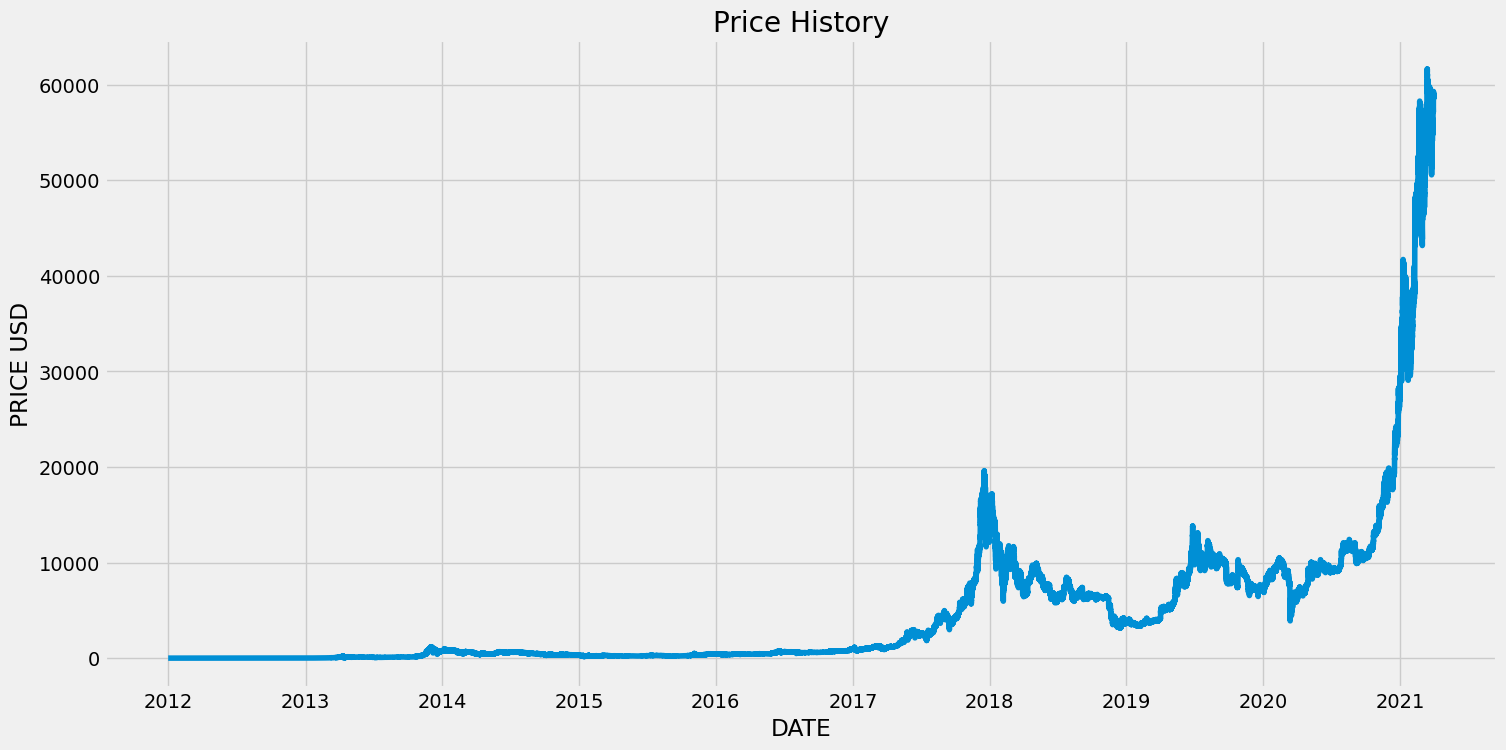

In [5]:
plt.figure(figsize=(16,8))
plt.title('Price History')
plt.plot(df1['Close'])
plt.xlabel('DATE')
plt.ylabel('PRICE USD')
plt.show()

In [6]:
data=df1.filter(['Close','Volume_(BTC)'])
dataset=data.values
dataset

array([[4.39000000e+00, 4.55580870e-01],
       [4.39000000e+00, 1.94756055e+00],
       [4.39000000e+00, 3.43954023e+00],
       ...,
       [5.87484500e+04, 7.05324530e-01],
       [5.86000000e+04, 3.00008631e+00],
       [5.87605900e+04, 7.20415490e-01]])

In [7]:
training_data_len=math.ceil(len(dataset)*0.80)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
training_data=scaled_data[0:training_data_len , :]

scaled_data

array([[8.62844749e-06, 1.00218106e-04],
       [8.62844749e-06, 4.28421916e-04],
       [8.62844749e-06, 7.56625726e-04],
       ...,
       [9.53283819e-01, 1.55156401e-04],
       [9.50874831e-01, 6.59955206e-04],
       [9.53480822e-01, 1.58476092e-04]])

In [8]:
xtrain=[]
ytrain=[]
n=60

# Data Shape:
# (samples , timesteps, features)


for i in range(n,len(training_data)):
    xtrain.append(training_data[i-n:i , :])
    ytrain.append(training_data[i,0])

xtrain , ytrain = np.array(xtrain),np.array(ytrain)
ytrain=np.reshape(ytrain , (ytrain.shape[0],1,1))


In [9]:
xtrain

array([[[8.62844749e-06, 1.00218106e-04],
        [8.62844749e-06, 4.28421916e-04],
        [8.62844749e-06, 7.56625726e-04],
        ...,
        [1.17116918e-05, 1.23074656e-03],
        [1.17116918e-05, 1.19414743e-03],
        [1.17116918e-05, 1.15754831e-03]],

       [[8.62844749e-06, 4.28421916e-04],
        [8.62844749e-06, 7.56625726e-04],
        [8.62844749e-06, 1.08482954e-03],
        ...,
        [1.17116918e-05, 1.19414743e-03],
        [1.17116918e-05, 1.15754831e-03],
        [1.17116918e-05, 1.12094918e-03]],

       [[8.62844749e-06, 7.56625726e-04],
        [8.62844749e-06, 1.08482954e-03],
        [8.62844749e-06, 1.41303335e-03],
        ...,
        [1.17116918e-05, 1.15754831e-03],
        [1.17116918e-05, 1.12094918e-03],
        [1.17116918e-05, 1.08435005e-03]],

       ...,

       [[1.30331684e-01, 9.06846517e-06],
        [1.30271966e-01, 1.50878860e-03],
        [1.30651043e-01, 3.98359434e-05],
        ...,
        [1.29560061e-01, 3.35494416e-06],
     

In [10]:
ytrain

array([[[1.17116918e-05]],

       [[1.17116918e-05]],

       [[1.17116918e-05]],

       ...,

       [[1.30006807e-01]],

       [[1.29797309e-01]],

       [[1.29827979e-01]]])

In [11]:

class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, recurrent_dropout=0.0, **kwargs):
        super(CustomLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_bias = use_bias
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.input_dim = input_shape[-1] # features number
        
        self.W_f = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_f')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', name='b_f') if self.use_bias else None
        
        self.W_i = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_i')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i') if self.use_bias else None
        
        self.W_c = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_c')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', name='b_c') if self.use_bias else None
        
        self.W_o = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_o')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', name='b_o') if self.use_bias else None

        self.W_s = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_s')
        self.b_s = self.add_weight(shape=(self.units,), initializer='zeros', name='b_s') if self.use_bias else None

        self.W_ff = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_ff')
        self.b_ff = self.add_weight(shape=(self.units,), initializer='zeros', name='b_ff') if self.use_bias else None
        
        self.W_fe = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_fe')
        self.b_fe = self.add_weight(shape=(self.units,), initializer='zeros', name='b_fe') if self.use_bias else None
        
        self.W_z = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z') if self.use_bias else None
        
        self.W_B = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_B')
        self.b_B = self.add_weight(shape=(self.units,), initializer='zeros', name='b_B') if self.use_bias else None
        
        

    def call(self, inputs, states, training=None):
        h_t, c_t, fe_t = states
        if 0 < self.recurrent_dropout < 1 and training:
            h_t = tf.nn.dropout(h_t, rate=self.recurrent_dropout)
        
        # print(inputs)
        # print(f'h_t.shape={h_t.shape}')
        # print(f'fe_t.shape={fe_t.shape}')
        # print(f'c_t.shape={c_t.shape}')
        # print(f'self.w_s.shape={self.W_s.shape}')
        concat_h_t = tf.concat([inputs, h_t], axis=-1)
        concat_fe_t = tf.concat([inputs, fe_t], axis=-1)
        concat_c_t = tf.concat([inputs, c_t], axis=-1)
        fe_hat = tf.matmul(concat_fe_t,self.W_s) + (self.b_s if self.use_bias else 0)
        fe_h= fe_hat + tf.matmul(concat_h_t,(1-self.W_s))+ (self.b_s if self.use_bias else 0)
        
        # print(f'fe_h_hat.shape={fe_h.shape}')
        # print('cell_here4')

        B_hat= tf.matmul(concat_c_t, self.W_B) + (self.b_B if self.use_bias else 0)
        f_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_f) + (self.b_f if self.use_bias else 0))
        i_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_i) + (self.b_i if self.use_bias else 0))
        c_hat_t = self.activation(tf.matmul(concat_h_t, self.W_c) + (self.b_c if self.use_bias else 0))
        o_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_o) + (self.b_o if self.use_bias else 0))
        # print('cell_here6')
        # print(B_hat)
        fe_1 = self.recurrent_activation(tf.matmul(B_hat,self.W_z) + (self.b_z if self.use_bias else 0))
        fe_2 = self.activation(tf.matmul(B_hat,self.W_fe) + (self.b_fe if self.use_bias else 0))
        # print('cell_here8')
        # print(f'fe_1{fe_1}')
        # print(f'fe_2{fe_2}')

        fe_f = tf.matmul(f_t, self.W_ff) + (self.b_ff if self.use_bias else 0)

        # print('code_here9')
        c_t_next = f_t * c_t + i_t * c_hat_t
        h_t_next = o_t * self.activation(c_t_next)
        # print('code_here10')
        fe_1_2=fe_1 * fe_2
        fe_ff = fe_t * fe_f
        # print ('code_here 11')
        # print (fe_1_2 ,fe_ff)
        fe_t_next=fe_1_2+fe_ff
        
        return h_t_next, [h_t_next, c_t_next, fe_t_next]
    

    def get_config(self):
        config = super(CustomLSTMCell, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation),
            'use_bias': self.use_bias,
            'recurrent_dropout': self.recurrent_dropout,
        })
        return config


class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False, return_state=False, recurrent_dropout=0.0, unroll=False, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.unroll = unroll
        self.cell = CustomLSTMCell(units, activation=activation, recurrent_activation=recurrent_activation, use_bias=use_bias, recurrent_dropout=recurrent_dropout)
        
    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        h_t = tf.zeros((batch_size, self.units))
        c_t = tf.zeros((batch_size, self.units))
        fe_t = tf.zeros((batch_size, self.units))
        
        states = [h_t, c_t, fe_t]
        
        inputs_transposed = tf.transpose(inputs, [1, 0, 2])
        
        def step(prev_states, x_t):
            
            h_t, c_t, fe_t = prev_states
            
            h_t, [h_t, c_t, fe_t] = self.cell(x_t, [h_t, c_t, fe_t], training=training)
            
            return [h_t, c_t, fe_t]

        if self.unroll:
            # Unroll the loop manually if unroll=True
            outputs = []
            for i in range(seq_length):
                states = step(states, inputs_transposed[i])
                outputs.append(states[0])
            outputs = tf.stack(outputs, axis=0)
            
        else:
            states = tf.scan(step, inputs_transposed, initializer=states, parallel_iterations=1)
            outputs = states[0]
            
        
        outputs = tf.transpose(outputs, [1, 0, 2])
        
        final_states = [states[0][-1], states[1][-1]]
        
        if self.return_sequences:
            if self.return_state:
                return outputs, final_states
            return outputs
        
        if self.return_state:
            return outputs[:, -1, :], final_states
        return outputs[:, -1, :]
    
    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.cell.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.cell.recurrent_activation),
            'use_bias': self.cell.use_bias,
            'return_sequences': self.return_sequences,
            'return_state': self.return_state,
            'recurrent_dropout': self.cell.recurrent_dropout,
            'unroll': self.unroll,
        })
        return config


In [ ]:
path = f'{project_name}/flstm'    

checkpoint_cb = ModelCheckpoint(
    filepath= f"{path}/model_epoch_{{epoch:02d}}_val_loss_{{val_loss:.2f}}.h5",
    save_best_only=True,
    monitor='val_mse',  # Change 'val_loss' to the primary metric you want to monitor
    mode='min'
)

inputs = tf.keras.Input(shape=(xtrain.shape[1],xtrain.shape[2]))
x = CustomLSTM(320, return_sequences=True)(inputs)
x = CustomLSTM(320)(x)
model_flstm = tf.keras.Model(inputs, x)
model_flstm.summary()
model_flstm.compile(optimizer='adam', loss='mse', metrics=['mae','mape','mse','msle','cosine_similarity'])
history_flstm=model_flstm.fit(xtrain,ytrain,batch_size=1024,epochs=7,validation_split=0.1, callbacks=[checkpoint_cb])
# Save the training history to a JSON file
with open(f'{path}/training_history.json', 'w') as f:
    json.dump(history_flstm.history, f)
count = count_folders(path)
model_flstm.save(f'{path}/MODEL_{count}.tf')

In [ ]:
path = f'{project_name}/lstm'    

# Define the ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=f"{path}/model_epoch_{{epoch:02d}}_val_loss_{{val_loss:.2f}}.h5",
    save_best_only=True,
    monitor='val_mse',
    mode='min'
)

inputs = tf.keras.Input(shape=(xtrain.shape[1],xtrain.shape[2]))
x = LSTM(320, return_sequences=True)(inputs)
x = LSTM(320)(x)
model_lstm = tf.keras.Model(inputs, x)
model_lstm.summary()
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae','mape','mse','msle','cosine_similarity'])
history_lstm=model_lstm.fit(xtrain,ytrain,batch_size=1024,epochs=7,validation_split=0.1, callbacks=[checkpoint_cb])
# Save the training history to a JSON file
with open(f'{path}/training_history.json', 'w') as f:
    json.dump(history_lstm.history, f)
    
count = count_folders(path)
model_lstm.save(f'{path}/MODEL_{count}.tf')

In [12]:
path = f'{project_name}/lstm'    
model_lstm=tf.keras.models.load_model(f'{path}/MODEL_0.tf')
print('********************************lstm')
model_lstm.summary()

2024-06-01 18:31:02.100601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-01 18:31:02.118472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-01 18:31:02.118610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-01 18:31:02.119001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

********************************lstm
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 64)            17152     
                                                                 
 dropout_11 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 448)           919296    
                                                                 
 dropout_12 (Dropout)        (None, 60, 448)           0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                131328    
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense) 

In [13]:
path = f'{project_name}/flstm'    
model_flstm=tf.keras.models.load_model(f'{path}/MODEL_0.tf')
print('********************************flstm')
model_flstm.summary()

********************************flstm
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_lstm_4 (CustomLSTM)  (None, 60, 32)            9888      
                                                                 
 custom_lstm_5 (CustomLSTM)  (None, 60, 288)           804384    
                                                                 
 dense_4 (Dense)             (None, 60, 736)           212704    
                                                                 
 dropout_2 (Dropout)         (None, 60, 736)           0         
                                                                 
 dense_5 (Dense)             (None, 60, 1)             737       
                                                                 
Total params: 1,027,713
Trainable params: 1,027,713
Non-trainable params: 0
_________________________________________________________________


In [14]:
test_data=scaled_data[training_data_len - n : , :]
xtest=[]
ytest=dataset[training_data_len : , 0]
for i in range(n , len(test_data)):
    xtest.append(test_data[i-n : i , :])

ytest=np.array(ytest)
xtest=np.array(xtest)

In [15]:
ytest

array([ 8013.58,  8020.58,  8021.03, ..., 58748.45, 58600.  , 58760.59])

In [16]:
xtest

array([[[1.30767557e-01, 2.48381631e-04],
        [1.31066470e-01, 1.09989370e-05],
        [1.31211707e-01, 9.15989097e-05],
        ...,
        [1.30006807e-01, 4.94223793e-05],
        [1.29797309e-01, 2.37079469e-05],
        [1.29827979e-01, 9.93100907e-05]],

       [[1.31066470e-01, 1.09989370e-05],
        [1.31211707e-01, 9.15989097e-05],
        [1.30933566e-01, 4.13931795e-07],
        ...,
        [1.29797309e-01, 2.37079469e-05],
        [1.29827979e-01, 9.93100907e-05],
        [1.29978571e-01, 2.48490162e-04]],

       [[1.31211707e-01, 9.15989097e-05],
        [1.30933566e-01, 4.13931795e-07],
        [1.30529174e-01, 6.13660700e-05],
        ...,
        [1.29827979e-01, 9.93100907e-05],
        [1.29978571e-01, 2.48490162e-04],
        [1.30092165e-01, 5.77541577e-05]],

       ...,

       [[9.39671944e-01, 1.59369773e-04],
        [9.40202262e-01, 1.46097437e-04],
        [9.40421011e-01, 2.91177411e-05],
        ...,
        [9.53195054e-01, 2.50548789e-05],
     

In [17]:
prediction_lstm=model_lstm.predict(xtest)

  24/2024 [..............................] - ETA: 9s 

2024-06-01 18:31:34.500764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8902
2024-06-01 18:31:34.536303: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2024/2024 [==============================] - 11s 5ms/step


In [18]:
prediction_lstm.shape

(64765, 1)

In [19]:
prediction_lstm

array([[0.1592647 ],
       [0.15932216],
       [0.159377  ],
       ...,
       [0.6137037 ],
       [0.61371857],
       [0.61303747]], dtype=float32)

In [20]:
prediction_flstm=model_flstm.predict(xtest)

2024/2024 [==============================] - 118s 58ms/step


In [21]:
prediction_flstm.shape

(64765, 60, 1)

In [22]:
prediction_flstm

array([[[0.12871338],
        [0.13078178],
        [0.1308316 ],
        ...,
        [0.12949654],
        [0.12936366],
        [0.12935421]],

       [[0.12903562],
        [0.13093749],
        [0.13064303],
        ...,
        [0.12936464],
        [0.12935388],
        [0.12947175]],

       [[0.12919302],
        [0.13068408],
        [0.13025804],
        ...,
        [0.12935393],
        [0.12947133],
        [0.12956873]],

       ...,

       [[0.8467096 ],
        [0.7970292 ],
        [0.78759104],
        ...,
        [0.77994233],
        [0.7794699 ],
        [0.7794919 ]],

       [[0.8472173 ],
        [0.7970414 ],
        [0.7879946 ],
        ...,
        [0.7794747 ],
        [0.7794888 ],
        [0.7796145 ]],

       [[0.84730667],
        [0.797551  ],
        [0.7883399 ],
        ...,
        [0.77949053],
        [0.7796162 ],
        [0.7786252 ]]], dtype=float32)

In [23]:
train=data[:training_data_len]
test=data[training_data_len:]

In [24]:
Predict_lstm_dataset_like = np.zeros(shape=(len(prediction_lstm), 2) )
Predict_lstm_dataset_like[:,0] = prediction_lstm[:,0]
prediction_lstm = scaler.inverse_transform(Predict_lstm_dataset_like)[:,0]
test['prediction_lstm']=prediction_lstm

/tmp/ipykernel_143310/2950209554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_lstm']=prediction_lstm


In [25]:

Predict_flstm_dataset_like = np.zeros(shape=(len(prediction_flstm), 2) )
Predict_flstm_dataset_like[:,0] = prediction_flstm[:,0]
prediction_flstm = scaler.inverse_transform(Predict_flstm_dataset_like)[:,0]
test['prediction_flstm']=prediction_flstm

ValueError: could not broadcast input array from shape (64765,1) into shape (64765,)

In [ ]:
test

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Close'],color='gray',label='Train')
plt.plot(test['Close'], color='blue', label='Test')
plt.plot(test['prediction_lstm'], color='green', label='Prediction_lstm')
plt.plot(test['prediction_flstm'], color='red', label='Prediction_flstm')
plt.legend(['Train','Test','Prediction_lstm','Prediction_flstm'])
plt.show()

In [ ]:
start_date = '2021-01-26 09:00:00'
end_date = '2021-03-30 23:00:00'
filtered_test = test.loc[start_date:end_date]
filtered_test

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(filtered_test['Close'], color='blue', label='Test')
plt.plot(filtered_test['prediction_lstm'], color='green', label='Prediction_lstm')
plt.plot(filtered_test['prediction_flstm'], color='red', label='Prediction_flstm')
plt.legend(['Test','Prediction_lstm','Prediction_flstm'])

In [ ]:
# Load the training history which is saved by checkpoint
path = f'{project_name}/lstm'    
with open(f'{path}/training_history.json', 'r') as f:
    history_lstm = json.load(f)

# Load the training history which is saved by checkpoint
path = f'{project_name}/flstm'    
with open(f'{path}/training_history.json', 'r') as f:
    history_flstm = json.load(f)
    
print('history_lstm:', history_lstm)
print('********************************')
print('history_flstm:', history_flstm)